In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
from lens import design
import matplotlib.pyplot as plt
from ionization import adk
from scipy.interpolate import interp1d
from scipy.optimize import newton
%load_ext autoreload
%autoreload 2

path = '/media/robert/Data_Storage/Data/Filamentation/'
lam = 0.8
tau = 35.

In [2]:
def plot_laser_plasma(I, ne, ext):
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    plt.show()

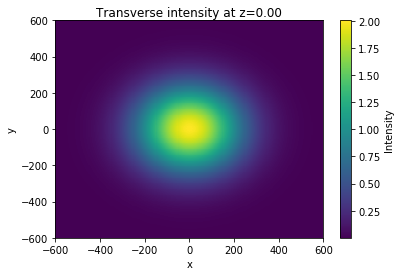

In [3]:
energy = 12e-3
w0 = 31
Nx = 2**8
X = 1200
Nz = 100
Z = 20e3
z0 = -40e3
z = np.linspace(-Z/2, Z/2, Nz)
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'z0' : z0,
    'name' : 'Test_Beam',
    'E0' : 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9,
    'waist' : w0
}

ext = [z[0]/1e3, z[-1]/1e3, -X/2, X/2]
beam = laserbeam.GaussianLaser(pulseParams)
beam.plot_current_intensity()
beam.propagate(z-z[0], 1.0)
e = np.zeros((Nz, Nx), dtype='complex128')
for i in range(Nz):
    e[i, :] = beam.load_field(i+1)[0]

In [4]:
a = 3.31743175609e+16 #cm-3
b = 0.00049976694808  #um-1
c = 2.39194210599e+14 #cm-3
n0 = 1e20
## sig(y) = sa + sb y + sc y**2     From ApproxGasJet_SigVSAxial.py
sa = 2986.91262632; sb = 0.550205150854; sc = -5.09030500347e-06

xaxis = np.reshape(beam.x, (Nx, 1, 1))
yaxis = np.reshape(beam.y, (1, Nx, 1))
zaxis = np.reshape(z, (1, 1, Nz))

y_expo = np.exp(-b*(yaxis))
xz_gauss = np.exp(-(np.square(xaxis)+np.square(zaxis))/(2*np.square(sa+sb*yaxis+sc*np.square(yaxis))))
n = n0 * y_expo * xz_gauss
n_slice = np.zeros((Nz, Nx))
n_slice = np.flip(np.transpose(n[:, int(Nx/2), :]), axis=0)

ne = n_slice*adk.gaussian_frac(ionization.H2['EI'], abs(e), tau, ionization.H2['Z'], ionization.H2['l'])
I = beam.intensity_from_field(e)

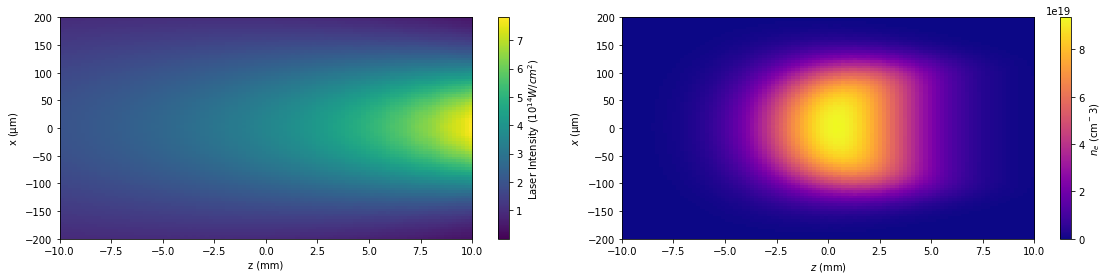

In [5]:
plot_laser_plasma(I, ne, ext)

In [6]:
energy = 12e-3
w0 = 31
Nx = 2**8
X = 1200
Nz = 100
Z = 20e3
z0 = -40e3
n0 = 2e18
z = np.linspace(-Z/2, Z/2, Nz)
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'z0' : z0,
    'name' : 'Test_Pulse',
    'E0' : 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9,
    'waist' : w0
}
plasmaParams = {
    'Nx' : Nx,
    'Ny' : Nx,
    'Nz' : Nz,
    'X' : X,
    'Y' : X,
    'Z' : Z,
    'atom' : ionization.H2,
    'path' : path,
    'load' : False,
    'cyl' : True,
    'name' : 'Test_Plasma',
    'n0' : n0/1e17
}
pulse = laserpulse.GaussianPulse(pulseParams)
print('Initial pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
ext = [z[0]/1e3, z[-1]/1e3, -X/2, X/2]
hydrogen = plasma.Plasma(plasmaParams)

xaxis = np.reshape(pulse.x, (Nx, 1, 1))
yaxis = np.reshape(pulse.y, (1, Nx, 1))
zaxis = np.reshape(z, (1, 1, Nz))

y_expo = np.exp(-b*(yaxis))
xz_gauss = np.exp(-(np.square(xaxis)+np.square(zaxis))/(2*np.square(sa+sb*yaxis+sc*np.square(yaxis))))
n = n0 * y_expo * xz_gauss / 1e17

# Initialize gas density
ne = np.zeros((Nx, Nx, Nz), dtype='double')
hydrogen.initialize_plasma(n, ne)

interactions.pulse_plasma(pulse, hydrogen)
print('Final pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
e = np.zeros((Nz, Nx), dtype='complex128')
ne = np.zeros((Nz, Nx))
for i in range(0, Nz-1):
    ne[i, :] = hydrogen.load_plasma_density(i)[0]
for i in range(Nz):
    e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
I = ionization.intensity_from_field(e)
ne = ne*1e17

Initial pulse energy 12.00mJ
Final pulse energy 12.00mJ


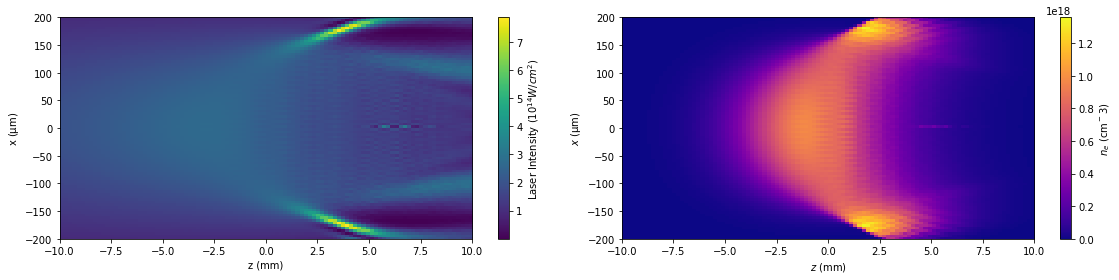

In [7]:
plot_laser_plasma(I, ne, ext)

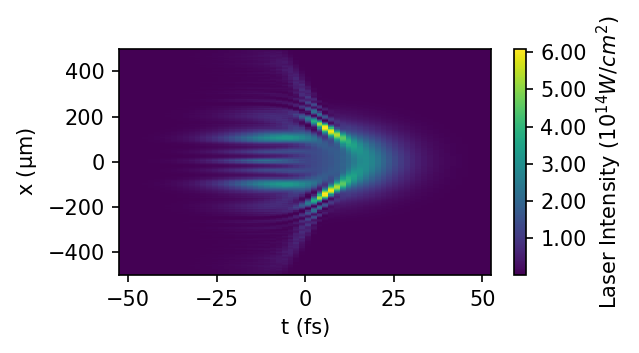

In [8]:
design.plot_pulse(pulse, 99, [-500, 500], False)

In [9]:
energy = 12e-3
w0 = 31
Nx = 2**8
X = 1200
Nz = 100
Z = 20e3
z0 = -40e3
n0 = 2e18
z = np.linspace(-Z/2, Z/2, Nz)
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'z0' : z0,
    'name' : 'Test_Pulse',
    'E0' : 2*np.sqrt(377*energy/np.pi/tau*1e15)/w0*1e6/1e9,
    'waist' : w0
}
plasmaParams = {
    'Nx' : Nx,
    'Ny' : Nx,
    'Nz' : Nz,
    'X' : X,
    'Y' : X,
    'Z' : Z,
    'atom' : ionization.H2,
    'path' : path,
    'load' : False,
    'cyl' : True,
    'name' : 'Test_Plasma',
    'n0' : n0/1e17
}
pulse2 = laserpulse.GaussianPulse(pulseParams)
print('Initial pulse energy %0.2fmJ' % (pulse2.pulse_energy()*1e3))
ext = [z[0]/1e3, z[-1]/1e3, -X/2, X/2]
hydrogen = plasma.Plasma(plasmaParams)

xaxis = np.reshape(pulse2.x, (Nx, 1, 1))
yaxis = np.reshape(pulse2.y, (1, Nx, 1))
zaxis = np.reshape(z, (1, 1, Nz))

y_expo = np.exp(-b*(yaxis))
xz_gauss = np.exp(-(np.square(xaxis)+np.square(zaxis))/(2*np.square(sa+sb*yaxis+sc*np.square(yaxis))))
n = n0 * y_expo * xz_gauss / 1e17

# Initialize gas density
ne = np.zeros((Nx, Nx, Nz), dtype='double')
hydrogen.initialize_plasma(n, ne)

interactions.pulse_plasma_energy(pulse2, hydrogen)
print('Final pulse energy %0.2fmJ' % (pulse2.pulse_energy()*1e3))
e = np.zeros((Nz, Nx), dtype='complex128')
ne = np.zeros((Nz, Nx))
for i in range(0, Nz-1):
    ne[i, :] = hydrogen.load_plasma_density(i)[0]
for i in range(Nz):
    e[i, :] = pulse2.load_field(i)[0][int(pulseParams['Nt']/2), :]
I = ionization.intensity_from_field(e)
ne = ne*1e17
print('Ionization energy %0.2fmJ' % (hydrogen.get_ionization_energy()*1e3))

Initial pulse energy 12.00mJ
Final pulse energy 11.04mJ
Ionization energy 0.96mJ


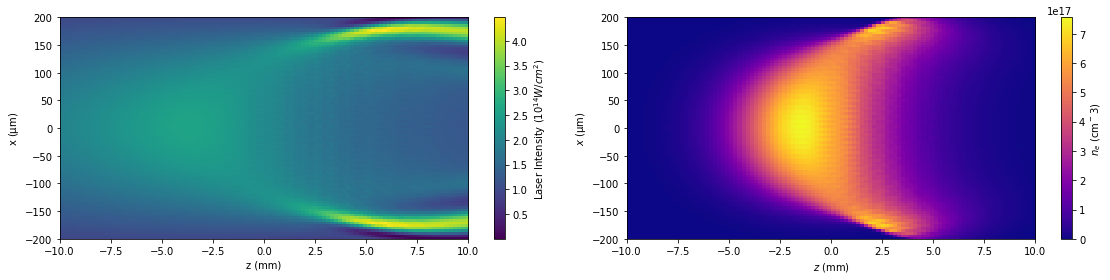

In [10]:
plot_laser_plasma(I, ne, ext)

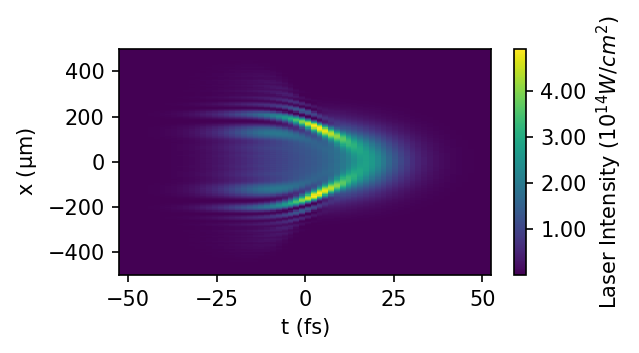

In [11]:
design.plot_pulse(pulse, 99, [-500, 500], False)